# Notebook d'analyse statistique et détection d'insights

In [126]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# pd.set_option("display.max_columns", 50)

## a. Données

In [2]:
df = pd.read_csv("./data/train.csv", sep=",")
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
df.shape

(891, 12)

## b. Analyse générale du jeu de données

In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

2 types présents : 
* numérique (PassengerId, Survived, Pclass, ...)
* textuel (Name, Sex, ...)

In [5]:
df.isna().sum() / df.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.000000
dtype: float64

2 colonnes sont gravement impactées par des valeurs manquantes : Age (20%) et Cabin (77%) 

Notons qu'en dehors de ces deux, seule Embarked contient aussi des valeurs manquantes.

## c. Analyse statistique des variables textuelles


In [6]:
textual_cols = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]

In [7]:
for col in textual_cols:
    data = (
        pd.concat(
            [
                df[col].fillna("isna").value_counts(),
                (df[col].fillna("isna").value_counts()/df.shape[0]).rename("prop")
            ], 
            axis=1,
        )
    )
    print(data)
    print("\n"*2 + "="*40 + "\n")

                                          count      prop
Name                                                     
Braund, Mr. Owen Harris                       1  0.001122
Boulos, Mr. Hanna                             1  0.001122
Frolicher-Stehli, Mr. Maxmillian              1  0.001122
Gilinski, Mr. Eliezer                         1  0.001122
Murdlin, Mr. Joseph                           1  0.001122
...                                         ...       ...
Kelly, Miss. Anna Katherine "Annie Kate"      1  0.001122
McCoy, Mr. Bernard                            1  0.001122
Johnson, Mr. William Cahoone Jr               1  0.001122
Keane, Miss. Nora A                           1  0.001122
Dooley, Mr. Patrick                           1  0.001122

[891 rows x 2 columns]



        count      prop
Sex                    
male      577  0.647587
female    314  0.352413



          count      prop
Ticket                   
347082        7  0.007856
CA. 2343      7  0.007856
1601          7 

### i. Name

Les noms sont au format : **Nom, Titre. Prénom "Surnom"**

In [8]:
def split_last(L, s):
    if isinstance(s, str):
        return L[:-1] + L[-1].split(s)
    elif isinstance(s, list):
        for s_ in s:
            if s_ in L[-1]:
                return L[:-1] + L[-1].split(s_)
    return L

def split_name(x):
    x = x.split(",")
    x = split_last(x, ".")
    x = split_last(x, ["(", "\""])
    return x

In [9]:
name_df = pd.concat([df["Name"], df["Name"].apply(lambda x: split_name(x)).apply(pd.Series)], axis=1)
name_df

,Name,0,1,2,3,4
0,"Braund, Mr. Owen Harris",Braund,Mr,Owen Harris,NaN,NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Mrs,John Bradley,Florence Briggs Thayer),NaN
2,"Heikkinen, Miss. Laina",Heikkinen,Miss,Laina,NaN,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Mrs,Jacques Heath,Lily May Peel),NaN
4,"Allen, Mr. William Henry",Allen,Mr,William Henry,NaN,NaN
...,...,...,...,...,...,...
886,"Montvila, Rev. Juozas",Montvila,Rev,Juozas,NaN,NaN
887,"Graham, Miss. Margaret Edith",Graham,Miss,Margaret Edith,NaN,NaN
888,"Johnston, Miss. Catherine Helen ""Carrie""",Johnston,Miss,Catherine Helen,Carrie,
889,"Behr, Mr. Karl Howell",Behr,Mr,Karl Howell,NaN,NaN


Titles analysis

In [10]:
name_df[1].value_counts()

1
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

**Common Social Titles:**

* Mr – Adult male.
* Miss – Unmarried female.
* Mrs – Married female.
* Ms – Female (marital status unspecified).
* Master – Traditionally for boys or young males.

**Professional / Religious Titles:**

* Dr – Doctor (medical or academic).
* Rev – Reverend (religious clergy).

**Military Titles:**

* Major – Military rank.
* Col – Colonel.
* Capt – Captain.

**Noble / Honorific Titles:**

* the Countess – Female count or wife/widow of a count.
* Sir – Knighted male or baronet.
* Lady – Female of nobility or wife of a knight.
* Don – Honorific used in Spanish/Italian cultures.
* Jonkheer – Dutch honorific for untitled nobility.

**French Titles:**

* Mlle – Mademoiselle (Miss).
* Mme – Madame (Mrs/Ms).

Family name

In [11]:
name_df[0].value_counts()

0
Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: count, Length: 667, dtype: int64

667 Noms uniques

Pistes : 
* utiliser le titre pour détecter le rang social, l'origine (Fr/En) et éventuellement le sexe en redondance
* utiliser le prénom pour regrouper par origine mais ça demande beaucoup de travail; mais je pense que l'origine peut être un facteur vraiment important parce que dans la situation d'urgence, la communication donc le langage et la langue et l'empathie qu'on peut ressentir pour ses semblables pourrait avoir poussé un favoritisme dans l'attribution des canots. 
* utiliser le nom pour le même but ou regrouper par famille mais je pense que ça ne serait pas particulièrement efficace. 

A l'issue de cette analyse et dans un premier temps, je ne vais juste pas considérer la variable nom.

### ii. Sex

In [12]:
df["Sex"].fillna("isna").value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

Pas de valeur manquante & 2/3 hommes. Variable non gravement déséquilibrée, sans traitement supplémentaire à effectuer. 

### iii. Embarked

In [13]:
df["Embarked"].fillna("isna").value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

2 valeurs manquantes

In [14]:
# Code executed before the modification of the dataset : df[df["Embarked"].isna()]

old_stone_dict = {
    'PassengerId': {61: 62, 829: 830},
    'Survived': {61: 1, 829: 1},
    'Pclass': {61: 1, 829: 1},
    'Name': {61: 'Icard, Miss. Amelie',
    829: 'Stone, Mrs. George Nelson (Martha Evelyn)'},
    'Sex': {61: 'female', 829: 'female'},
    'Age': {61: 38.0, 829: 62.0},
    'SibSp': {61: 0, 829: 0},
    'Parch': {61: 0, 829: 0},
    'Ticket': {61: '113572', 829: '113572'},
    'Fare': {61: 80.0, 829: 80.0},
    'Cabin': {61: 'B28', 829: 'B28'},
    'Embarked': {61: np.nan, 829: np.nan}
}
pd.DataFrame(old_stone_dict)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Titanica : 

"*Miss Rose Amélie Icard, 38 [...] boarded the Titanic at Southampton as maid to Mrs George Nelson Stone. She travelled on Mrs Stone's ticket (#113572).*"

"*Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*"

Perchance, the test dataset does not contain embarked missing values. 

### iv. Cabin

In [15]:
cabin_df = (
    df["Cabin"]
    .to_frame()
    .dropna(subset=["Cabin"])
    .assign(
        nb_spaces = lambda x: x.Cabin.str.count(" ")+1,
        nb_cars = lambda x: x.Cabin.str.len()
    )
)

cabin_df.sort_values("nb_spaces", ascending=False)

,Cabin,nb_spaces,nb_cars
742,B57 B59 B63 B66,4,15
311,B57 B59 B63 B66,4,15
341,C23 C25 C27,3,11
27,C23 C25 C27,3,11
438,C23 C25 C27,3,11
...,...,...,...
332,C91,1,3
336,C2,1,2
337,E40,1,3
339,T,1,1


#### Analyse des multi-cabines

Il n'y a que 8 cas de multi-cabines

Exemple de multi-cabine détenues par deux personnes (Mme et sa servante).

In [16]:
df[df["Cabin"] == "B57 B59 B63 B66"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C


De ce que j'ai compris : il y a des cabines qui ont été pris à leur nom pour plusieurs personnes

#### Analyse des cabines sans numéro

4 cas : Dx ou Tx

In [17]:
cabin_df.sort_values("nb_cars")

,Cabin,nb_spaces,nb_cars
292,D,1,1
473,D,1,1
327,D,1,1
339,T,1,1
618,F4,1,2
...,...,...,...
341,C23 C25 C27,3,11
679,B51 B53 B55,3,11
27,C23 C25 C27,3,11
311,B57 B59 B63 B66,4,15


In [18]:
df[df["Cabin"].str.len()<2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5000,T,S
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C


Ce sont des personnes pour lesquelles la cabine exacte n'est pas connue : 

"Lévy boarded the Titanic at Cherbourg as a second-class passenger (ticket number SC/PARIS 2163, £12 17s 6d). He **shared a cabin with Jean-Noël Malachard** and an unidentified man."

In [21]:
df[df["Name"].str.contains("Malachard")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


#### Analyse des ponts

Les ponts sont du haut vers le bas : 
* Boat Deck 
* A Deck 
* B Deck 
* C Deck 
* D Deck 
* E Deck 
* F Deck 
* G Deck 
* Orlop Deck 
* Tank Top

Tout ce qui est B-Deck et au-dessus fait partie surtout de la superstructure visible du navire. Toutes les cabines jusqu'au G-Deck sous au-dessus de la ligne d'eau. Le pont où se trouvent les canots initialement au Boat Deck. 

Question : Est-ce que toutes les cabines ont le même deck ?

In [66]:
df_cabin = df.dropna(subset=["Cabin"])
df_cabin["nb_decks"] = df_cabin.loc[:, "Cabin"].apply(lambda x: len(np.unique([c[0] for c in x.split(" ")])))
df_cabin.loc[:, ["Cabin", "nb_decks"]].sort_values(by="nb_decks", ascending=False)

C:\Users\mathi\AppData\Local\Temp\ipykernel_11736\4165246641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cabin["nb_decks"] = df_cabin.loc[:, "Cabin"].apply(lambda x: len(np.unique([c[0] for c in x.split(" ")])))


,Cabin,nb_decks
75,F G73,2
128,F E69,2
699,F G63,2
715,F G73,2
1,C85,1
...,...,...
327,D,1
329,B18,1
331,C124,1
332,C91,1


In [67]:
df_cabin[df_cabin["nb_decks"]>1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nb_decks
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S,2
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,2
699,700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.6500,F G63,S,2
715,716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.6500,F G73,S,2


Toutes ces personnes sont sur deux étages possibles d'affilés donc on peut range encoder et mettre un flottant pour ces cas-là.

In [102]:
decks_encoding = "TABCDEFGHI"

def transform_cabin_float(x):
    if pd.isna(x):
        return np.nan
    decks = [
        decks_encoding.index(c[0])
        for c in x.split(" ")
    ]
    return np.mean(decks)

df["Cabin"].apply(transform_cabin_float).value_counts()

Cabin
3.0    59
2.0    47
4.0    33
5.0    32
1.0    15
6.0     9
7.0     4
6.5     3
5.5     1
0.0     1
Name: count, dtype: int64

#### Analyse du bord

In [105]:
def extract_cabin_bord(x):
    if pd.isna(x):
        return np.nan
    decks = [
        int(c[1:])%2==0 if len(c[1:]) > 0 else np.nan
        for c in x.split(" ")
    ]
    return decks

df["Cabin"].apply(extract_cabin_bord)

0          NaN
1      [False]
2          NaN
3      [False]
4          NaN
        ...   
886        NaN
887     [True]
888        NaN
889     [True]
890        NaN
Name: Cabin, Length: 891, dtype: object

In [108]:
multi_cabin_mask = df["Cabin"].str.count(" ") > 1
df[multi_cabin_mask]["Cabin"]

27         C23 C25 C27
88         C23 C25 C27
311    B57 B59 B63 B66
341        C23 C25 C27
438        C23 C25 C27
679        B51 B53 B55
742    B57 B59 B63 B66
872        B51 B53 B55
Name: Cabin, dtype: object

Ici, ces multi-cabines sont souvent toutes du même bord. Mais "B57 B59 B63 B66" sont 3 impairs & 1 pair.

In [109]:
multi_cabin_mask = df["Cabin"].str.count(" ") > 1

pd.concat([df["Cabin"], df["Cabin"].apply(extract_cabin_bord)], axis=1).dropna().loc[multi_cabin_mask]

,Cabin,Cabin
27,C23 C25 C27,"[False, False, False]"
88,C23 C25 C27,"[False, False, False]"
311,B57 B59 B63 B66,"[False, False, False, True]"
341,C23 C25 C27,"[False, False, False]"
438,C23 C25 C27,"[False, False, False]"
679,B51 B53 B55,"[False, False, False]"
742,B57 B59 B63 B66,"[False, False, False, True]"
872,B51 B53 B55,"[False, False, False]"


On doit donc passer par le mode et non pas la moyenne. (ici en binaire c'est la médiane)

In [114]:
def extract_cabin_bord(x):
    if pd.isna(x):
        return np.nan
    decks = [
        int(c[1:])%2==0 if len(c[1:]) > 0 else np.nan
        for c in x.split(" ")
    ]
    return np.median(decks)

In [115]:
pd.concat([df["Cabin"], df["Cabin"].apply(extract_cabin_bord)], axis=1).dropna()

,Cabin,Cabin
1,C85,0.0
3,C123,0.0
6,E46,1.0
10,G6,1.0
11,C103,0.0
...,...,...
871,D35,0.0
872,B51 B53 B55,0.0
879,C50,1.0
887,B42,1.0


In [117]:
df["Cabin"].apply(extract_cabin_bord).fillna("isna").value_counts()

Cabin
isna    695
1.0     108
0.0      88
Name: count, dtype: int64

Je ne sais pas trop comment anticiper les valeurs manquantes...

### v. Ticket

J'ai l'impression qu'il y a un radical et un numéro de ticket

In [77]:
def first_approach_ticket(x):
    x = x.split(" ")
    if len(x) == 0:
        return [np.nan, np.nan]
    if len(x) == 1:
        return [np.nan, x[0]]
    if len(x) == 2:
        return x
    return [" ".join(x[:-1]), x[-1]]


df["Ticket"].apply(first_approach_ticket).apply(pd.Series)

,0,1
0,A/5,21171
1,PC,17599
2,STON/O2.,3101282
3,NaN,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,NaN,112053
888,W./C.,6607
889,NaN,111369


In [82]:
ticket_transform_df = df.copy(deep=True)
ticket_transform_df[["ticket_prefix", "ticket_number"]] = df["Ticket"].apply(first_approach_ticket).apply(pd.Series)

#### Préfixe

In [83]:
ticket_transform_df["ticket_prefix"].value_counts()

ticket_prefix
PC             60
C.A.           27
STON/O 2.      12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
F.C.C.          5
C               5
SC/PARIS        5
S.O.C.          5
SC/Paris        4
A/4.            3
S.O./P.P.       3
PP              3
A/4             3
A.5.            2
S.C./PARIS      2
SOTON/O2        2
P/PP            2
SC/AH           2
WE/P            2
A./5.           2
SC/AH Basle     1
SO/C            1
S.W./PP         1
F.C.            1
A/S             1
SW/PP           1
SC              1
SCO/W           1
W/C             1
Fa              1
S.O.P.          1
S.C./A.4.       1
A4.             1
S.P.            1
W.E.P.          1
C.A./SOTON      1
Name: count, dtype: int64

#### Numéro

## d. Analyse statistique des variables numériques

In [84]:
numerical_cols = ["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]

In [85]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId n'est pas à leaker. 

### i. Pclass

<Axes: >

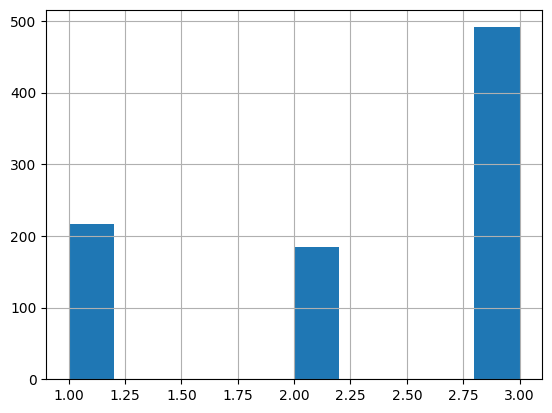

In [87]:
df["Pclass"].hist()

C'est bon, c'est équilibré.

### ii. Age

<Axes: >

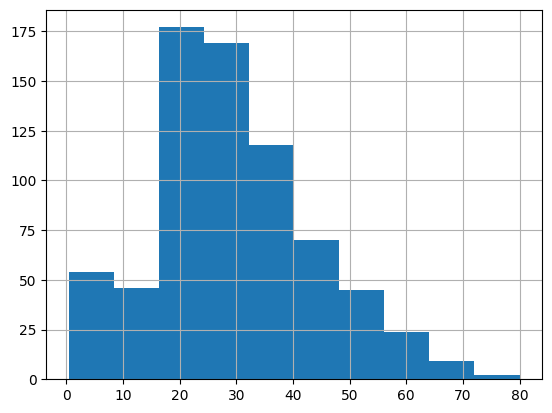

In [88]:
df["Age"].hist()

Semble équilibré

In [94]:
df["Age"].isna().sum()

np.int64(177)

In [96]:
df["Age"].mean(), df["Age"].median()

(np.float64(29.69911764705882), np.float64(28.0))

On peut avior deux approches : 
* imputer par moyenne (29.7) ou médiane (28.0)
* knn imputer sur les autres colonnes. En effet, on pourrait justifier que la classe sociale, le choix de la chambre 

<Axes: >

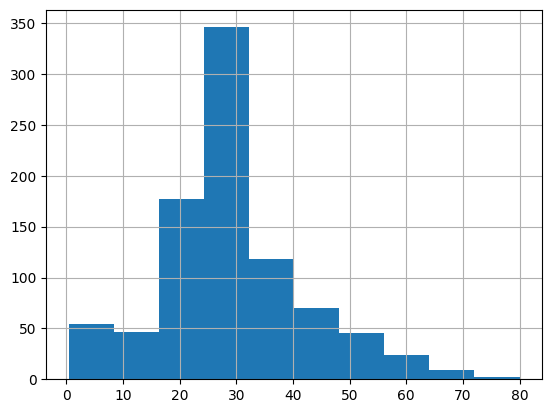

In [ ]:
(
    df["Age"]
    .fillna(df["Age"].mean())
    .hist()
)

In [139]:
min_max_scaler = MinMaxScaler()
df_min_max_scaled = min_max_scaler.fit_transform(df[numerical_cols])

knn_imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
data_imputed = knn_imputer.fit_transform(df_min_max_scaled)

descaled_data_imputed = min_max_scaler.inverse_transform(data_imputed)

In [149]:
descaled_data_imputed_df = pd.DataFrame(descaled_data_imputed, columns=numerical_cols)
descaled_data_imputed_df

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0.0,3.0,22.000000,1.0,0.0,7.2500
1,1.0,1.0,38.000000,1.0,0.0,71.2833
2,1.0,3.0,26.000000,0.0,0.0,7.9250
3,1.0,1.0,35.000000,1.0,0.0,53.1000
4,0.0,3.0,35.000000,0.0,0.0,8.0500
...,...,...,...,...,...,...
886,0.0,2.0,27.000000,0.0,0.0,13.0000
887,1.0,1.0,19.000000,0.0,0.0,30.0000
888,0.0,3.0,25.666667,1.0,2.0,23.4500
889,1.0,1.0,26.000000,0.0,0.0,30.0000


<Axes: >

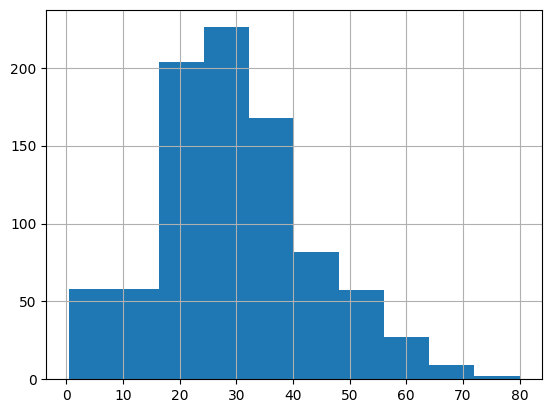

In [ ]:
# descaled_data_imputed[:,numerical_cols.index("Age")]
descaled_data_imputed_df["Age"].hist()

Bon c'est mieux en distribution que du constant-imputer et peut-être mieux que du fequency-imputing parce qu'il doit y avoir même marginalement un peu plus de structure.

### iii. SibSp & Parch

<Axes: >

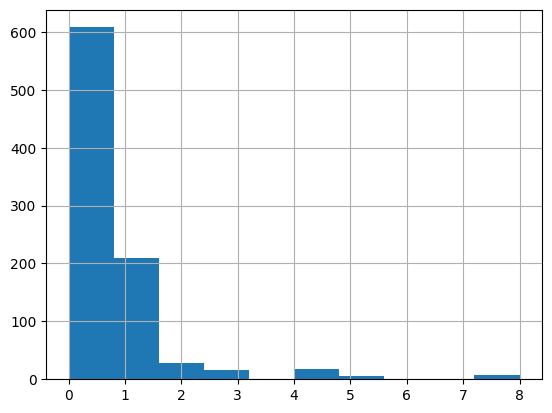

In [89]:
df["SibSp"].hist()

In [150]:
df[df["SibSp"] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<Axes: >

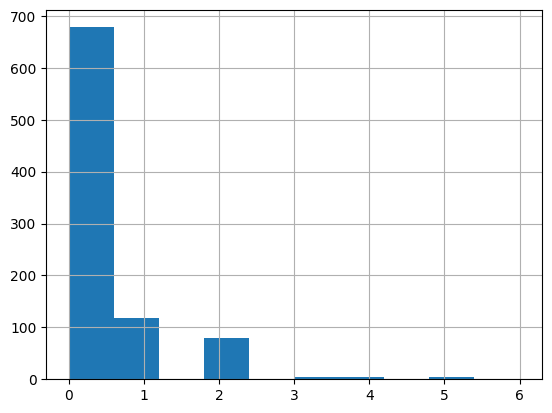

In [90]:
df["Parch"].hist()

In [151]:
df[df["Parch"] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Considérer une transformation log

### iv. Fare

<Axes: >

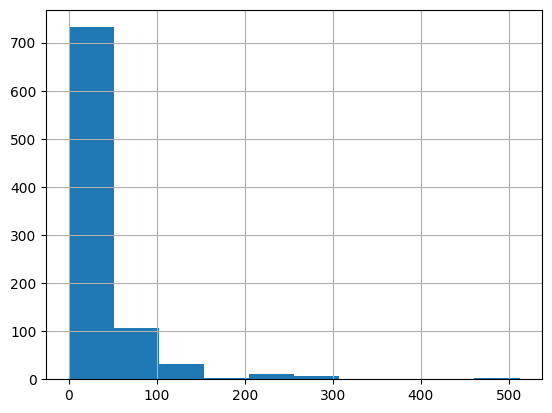

In [91]:
df["Fare"].hist()

In [152]:
df[df["Fare"] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


<Axes: >

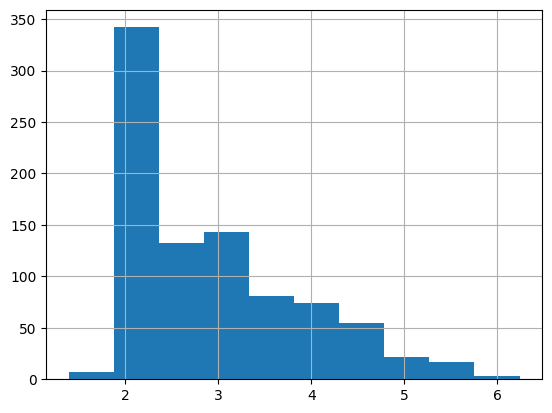

In [157]:
(
    df[df["Fare"] > 0]
    .loc[:,"Fare"]
    .apply(np.log)
    .hist()
)

Pareil, déséquilibré gauche transfo log

### v. Survived

<Axes: >

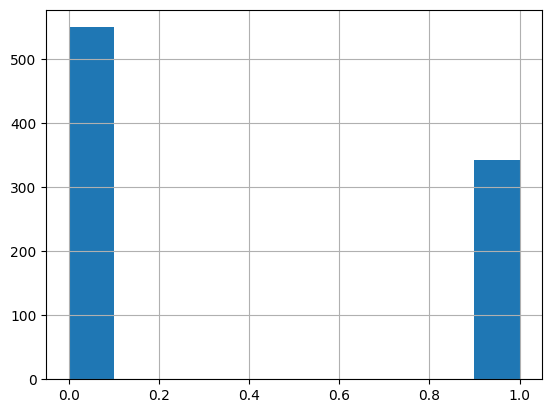

In [93]:
df["Survived"].hist()

C'est bien équilibré !